### Бэггинг - построение ансамбля классификаторов из бутстрэп-образцов
В данном методе вместо использования подгонки индивидуальных классификаторов в ансамбле того-же самого обучающего набора мы производим выборку бутстрэп-образцов (случайных образцов с возвращением) из первоначального набора

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [4]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
data.columns = ['Метка класса','Алкоголь','Яблочная кислота',
                'Зола','Щелочность золы','Магний','Всего фенолов','Флавоноиды','Нефлавоноидные фенолы',
               'Проантоцианидины','Интенсивность цвета','Оттенок','OD280/OD315 разбавленных вин','Пролин']
# Отбросим класс 1
data = data[data['Метка класса'] != 1]
X = data[['Алкоголь','OD280/OD315 разбавленных вин']].values
y = data['Метка класса'].values

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [9]:
tree = DecisionTreeClassifier(criterion='entropy',random_state=1, max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True,bootstrap_features=False,
                       n_jobs=1, random_state=1)

In [11]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Меры правильности дерева принятия решений при обучении/испытании %.3f/%.3f' % (tree_train, tree_test))

Меры правильности дерева принятия решений при обучении/испытании 1.000/0.833


В качестве базового классификатора будем применять неподрезанное дерево принятия решений и создадим ансамбль 500 таких деревьев

In [12]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Меры правильности бэггинга при обучении/испытании %.3f/%.3f' % (bag_train, bag_test))

Меры правильности бэггинга при обучении/испытании 1.000/0.917


Сравним области решений классификаторов 

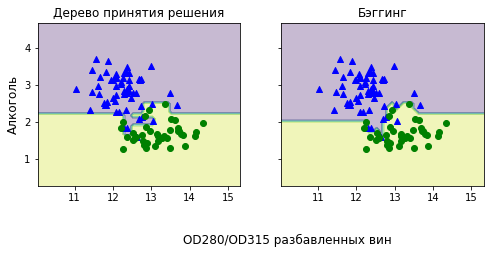

In [20]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,sharex='col',
                       sharey='row',
                       figsize=(8,3))
for idx, clf, tt in zip([0,1],[tree, bag], ['Дерево принятия решения','Бэггинг']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],X_train[y_train==0,1], c='blue',marker='^')
    axarr[idx].scatter(X_train[y_train==1,0],X_train[y_train==1,1], c='green',marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Алкоголь',fontsize=12)
plt.text(10.2, -1.2, s='OD280/OD315 разбавленных вин', ha='center',va='center',fontsize=12)
plt.show()

### Использование слабых учеников посредством адаптивного бустинга
**Адаптивный бустинг**(Adaptive Boosting - AdaBoost)
Рассмотрим алгоритм:
    1. Производим выборку случайного поднабора обучающих образцов d1 без возвращения из обучающего набора D для обучения слабого ученика C1
    2. Производим выборку второго случайного поднабора обучающих образцов d2 без возвращения из обучающего набора и добавляем 50% образцов, которые ранее были неправильно классифицированы, для обучения слабого ученика C2
    3. Находим в обучающем наборе D обучающие образцы d3, по которым С1 и С2 расходятся, для обучения третьего слабого ученика C3
    4. Объединяем слабых учеников C1,C2,C3 посредством мажоритарного голосования

In [22]:
tree = DecisionTreeClassifier(criterion='entropy',random_state=1, max_depth=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Меры правильности дерева принятия решений при обучении/испытании %.3f/%.3f' % (tree_train, tree_test))

Меры правильности дерева принятия решений при обучении/испытании 0.916/0.875


In [24]:
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('Меры правильности дерева принятия решений при обучении/испытании %.3f/%.3f' % (ada_train, ada_test))

Меры правильности дерева принятия решений при обучении/испытании 1.000/0.917


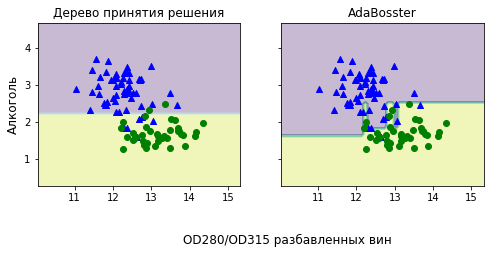

In [25]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,sharex='col',
                       sharey='row',
                       figsize=(8,3))
for idx, clf, tt in zip([0,1],[tree, ada], ['Дерево принятия решения','AdaBosster']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],X_train[y_train==0,1], c='blue',marker='^')
    axarr[idx].scatter(X_train[y_train==1,0],X_train[y_train==1,1], c='green',marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Алкоголь',fontsize=12)
plt.text(10.2, -1.2, s='OD280/OD315 разбавленных вин', ha='center',va='center',fontsize=12)
plt.show()